In [166]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [87]:
audio_folder = '/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/processed_audio_0'
files = os.listdir(audio_folder)

In [227]:
col_names = ['video_id', 'frames']
mfcc = ['mfcc_' + str(i) for i in range(13)]
chroma = ['chroma_' + str(i) for i in range(12)]
col_names.extend(mfcc)
col_names.extend(chroma)

mean = []
std = []
max_ = []
min_ = []
interquantile = []

# read each audio file and find its mean, std, quantile values
for f in files:
    df = pd.read_csv(os.path.join(audio_folder, f), index_col=0)
    
    # drop first and last 30 frames because they have 0's sometimes
    df.drop(df.head(30).index, inplace=True)
    df.drop(df.tail(30).index, inplace=True)
    
    video_id = f[6:-4]
    frames = df.shape[0]
    if frames == 0:
        continue
    
    # add mean, std, quantile values of each video to the overall corresponding lists
    data_list = [video_id, frames]
    mean_list = df.mean(axis=0).tolist()
    data_list.extend(mean_list)
    mean.append(data_list)
    
    data_list = [video_id, frames]
    std_list = df.std(axis=0).tolist()
    data_list.extend(std_list)
    std.append(data_list)
    
    data_list = [video_id, frames]
    max_list = df.max(axis=0).tolist()
    data_list.extend(max_list)
    max_.append(data_list)
    
    data_list = [video_id, frames]
    min_list = df.min(axis=0).tolist()
    data_list.extend(min_list)
    min_.append(data_list)
    
    data_list = [video_id, frames]
    first_quantile = df.quantile(0.25, axis=0).to_numpy()
    last_quantile = df.quantile(0.75, axis=0).to_numpy()
    interquantile_list = first_quantile - last_quantile
    data_list.extend(interquantile_list.tolist())
    interquantile.append(data_list)


# create dataframes
mean_df = pd.DataFrame(data=mean, columns=col_names)
std_df = pd.DataFrame(data=std, columns=col_names)
max_df = pd.DataFrame(data=max_, columns=col_names)
min_df = pd.DataFrame(data=min_, columns=col_names)
interquantile_df = pd.DataFrame(data=interquantile, columns=col_names)


In [228]:
# create final csv files for audio analysis
audio_analysis_folder = '/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/audio_analysis'

mean_df.to_csv(os.path.join(audio_analysis_folder, 'audio_mean.csv'), index=False)
std_df.to_csv(os.path.join(audio_analysis_folder, 'audio_std.csv'), index=False)
max_df.to_csv(os.path.join(audio_analysis_folder, 'audio_max.csv'), index=False)
min_df.to_csv(os.path.join(audio_analysis_folder, 'audio_min.csv'), index=False)
interquantile_df.to_csv(os.path.join(audio_analysis_folder, 'audio_interquantile.csv'), index=False)


In [231]:
mean_df_cp = mean_df.copy()
std_df_cp = std_df.copy()
max_df_cp = max_df.copy()
min_df_cp = min_df.copy()
interquantile_df_cp = interquantile_df.copy()

# take videos of length between 3.5 to 20 mins
mean_df_cp = mean_df_cp[mean_df_cp['frames'].between(600, 3500)]
std_df_cp = std_df_cp[std_df_cp['frames'].between(600, 3500)]
max_df_cp = max_df_cp[max_df_cp['frames'].between(600, 3500)]
min_df_cp = min_df_cp[min_df_cp['frames'].between(600, 3500)]
interquantile_df_cp = interquantile_df_cp[interquantile_df_cp['frames'].between(600, 3500)]

# get ids of selected videos
selected_ids = mean_df_cp['video_id'].tolist()
print('Number of selected videos for audio analysis: ', len(selected_ids))

Number of selected videos for audio analysis:  3395


(-0.021500000000000002, -0.00398]       8
(-0.00398, 0.0124]                   1321
(0.0124, 0.0288]                     1638
(0.0288, 0.0452]                      367
(0.0452, 0.0615]                       48
(0.0615, 0.0779]                        7
(0.0779, 0.0943]                        2
(0.0943, 0.111]                         1
(0.111, 0.127]                          1
(0.127, 0.143]                          2
dtype: int64
(-0.00010599999999999997, 0.00536]    362
(0.00536, 0.00979]                    591
(0.00979, 0.0142]                     617
(0.0142, 0.0186]                      580
(0.0186, 0.0231]                      444
(0.0231, 0.0275]                      302
(0.0275, 0.0319]                      212
(0.0319, 0.0363]                      109
(0.0363, 0.0408]                       77
(0.0408, 0.0452]                      101
dtype: int64
(-0.002, 0.1]    362
(0.1, 0.2]       591
(0.2, 0.3]       617
(0.3, 0.4]       580
(0.4, 0.5]       444
(0.5, 0.6]       302
(0.6, 0.

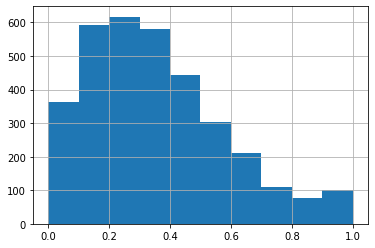

In [233]:
# process data and calculate popularity
raw_data_file = '/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/Data/raw_data.csv'
raw_df = pd.read_csv(raw_data_file, index_col=0)
raw_df = raw_df[raw_df['video_id'].isin(selected_ids)]
raw_df = raw_df[['video_id', 'video_likeCount', 'video_dislikeCount', 'video_viewCount']]

# calculate popularity rating with (video_likeCount - video_dislikeCount) / video_viewCount
rating = raw_df['video_likeCount'].to_numpy() - raw_df['video_dislikeCount'].to_numpy()
rating = rating / raw_df['video_viewCount'].to_numpy()
raw_df['raw_rating'] = rating

data0 = pd.Series(rating)
print(data0.value_counts(bins=10).sort_index())
#data0.hist(bins=10)

# clip bottom 36 and top 61
rating3 = np.clip(rating, 0.000938, 0.0452)
data3 = pd.Series(rating3)
print(data3.value_counts(bins=10).sort_index())
#data3.hist(bins=10)

min_max_scaler = preprocessing.MinMaxScaler()
rating = min_max_scaler.fit_transform(rating3.reshape(-1,1))
data = pd.Series(rating.squeeze())
print(data.value_counts(bins=10).sort_index())
data.hist(bins=10)

raw_df['rating'] = rating

raw_df.to_csv(os.path.join(audio_analysis_folder, 'rating.csv'), index=False)

In [234]:
# get rating values in order of video ids in audio datasets
rating_list = []
for vid in selected_ids:
    rating = raw_df.loc[raw_df['video_id'] == vid]['raw_rating'].item()
    rating_list.append(rating)

mean_df_cp['rating'] = rating_list
std_df_cp['rating'] = rating_list
max_df_cp['rating'] = rating_list
min_df_cp['rating'] = rating_list
interquantile_df_cp['rating'] = rating_list

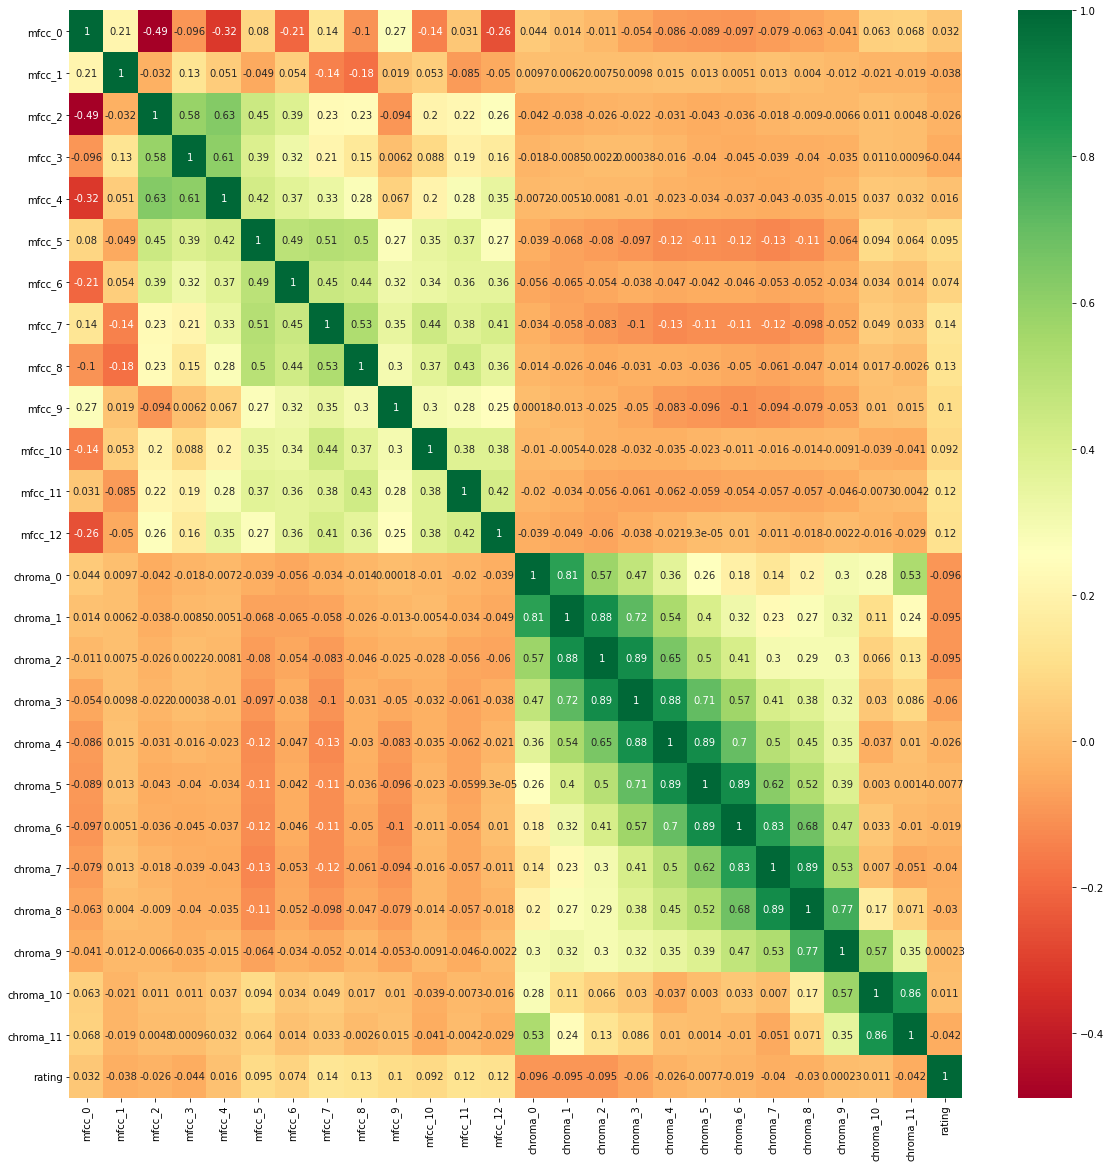

In [235]:
# visualize correlation between mean of audio features
data = mean_df_cp.drop(['video_id', 'frames'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

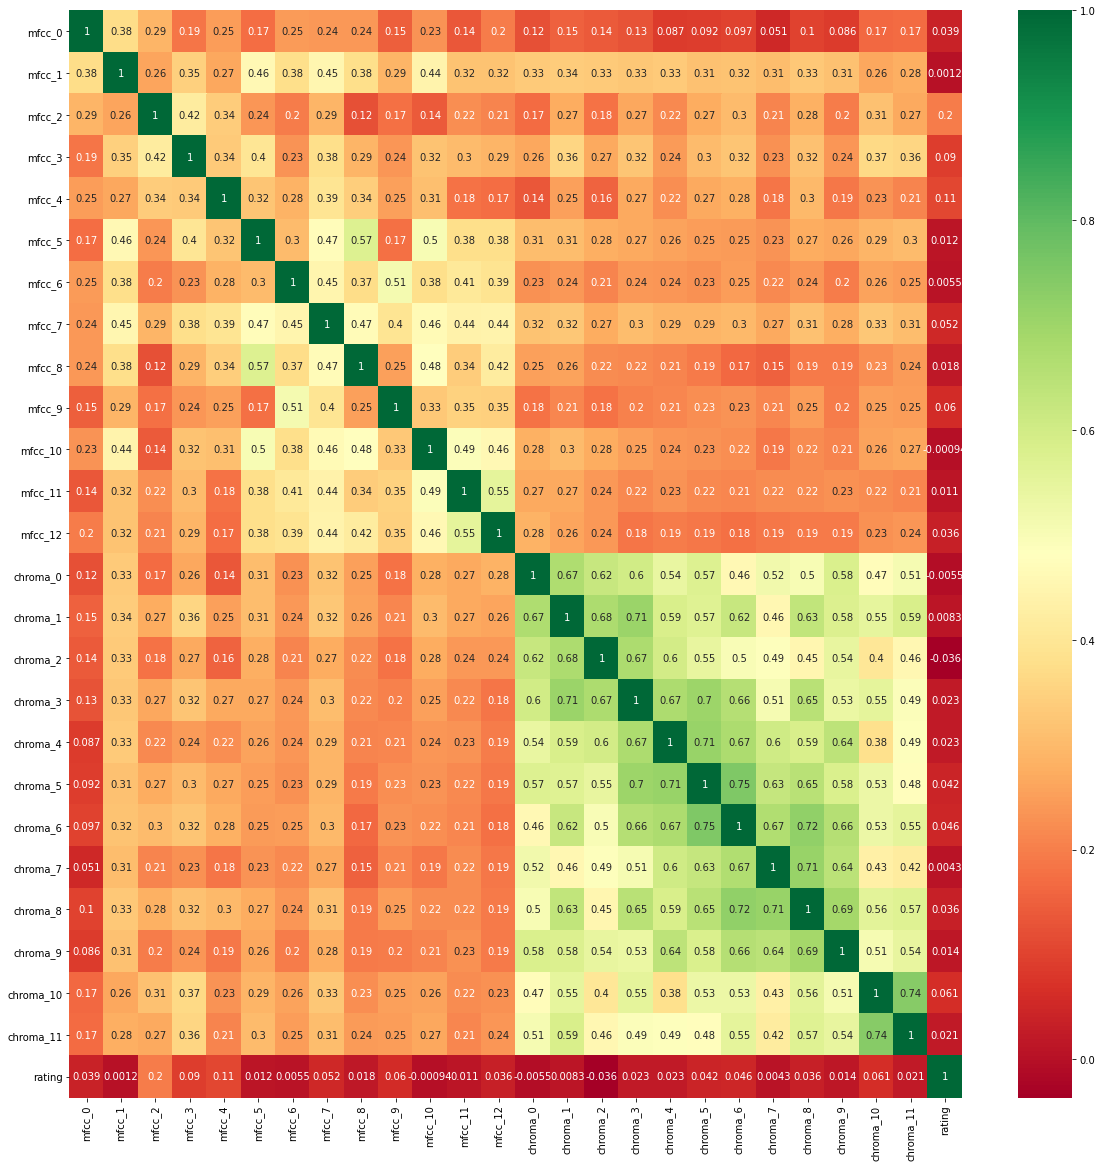

In [236]:
# visualize correlation between std of audio features
data = std_df_cp.drop(['video_id', 'frames'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

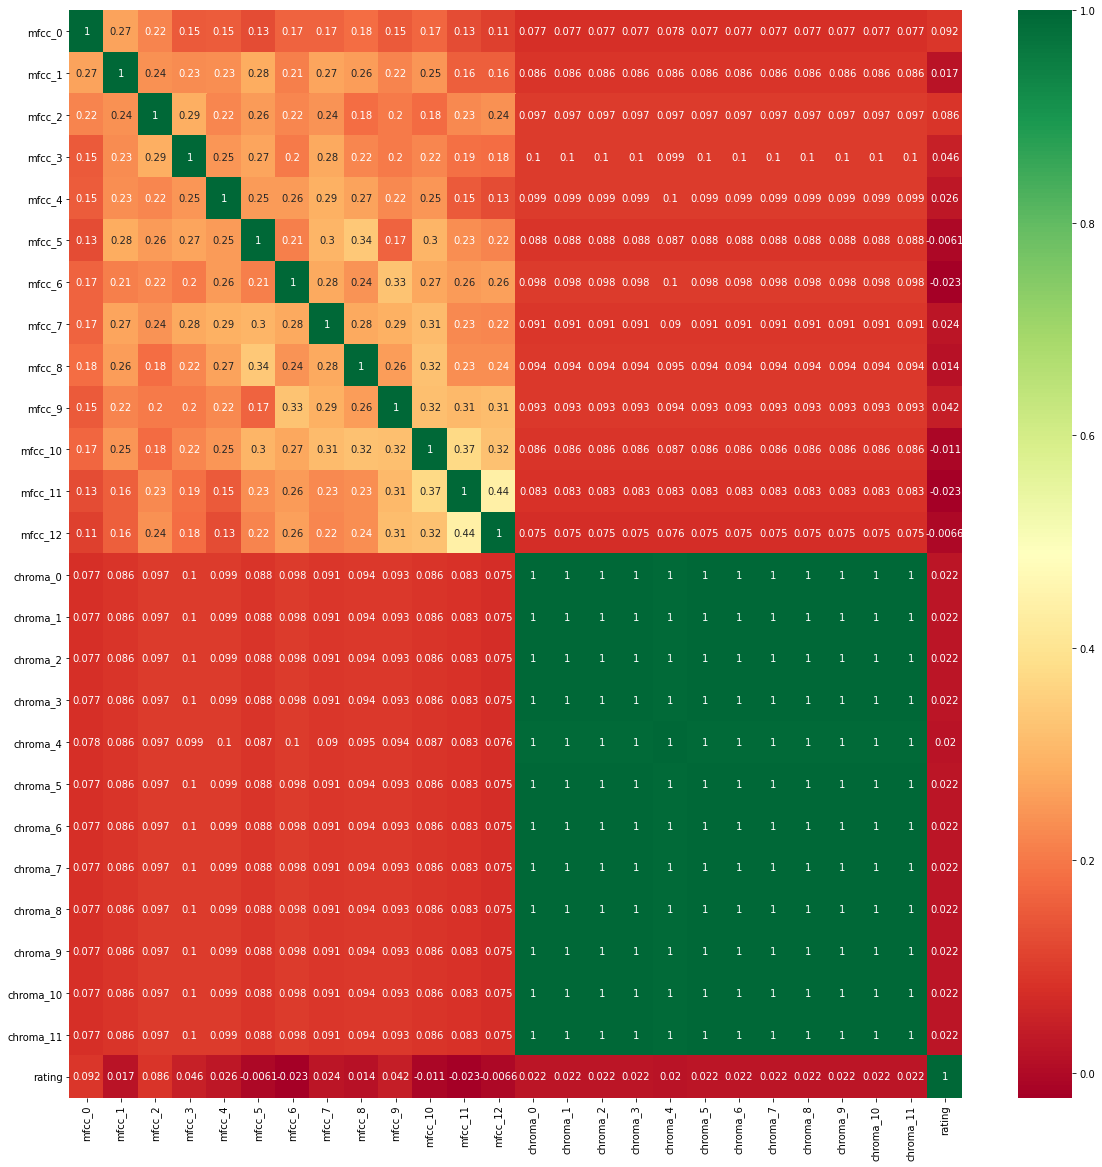

In [237]:
# visualize correlation between max of audio features
data = max_df_cp.drop(['video_id', 'frames'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

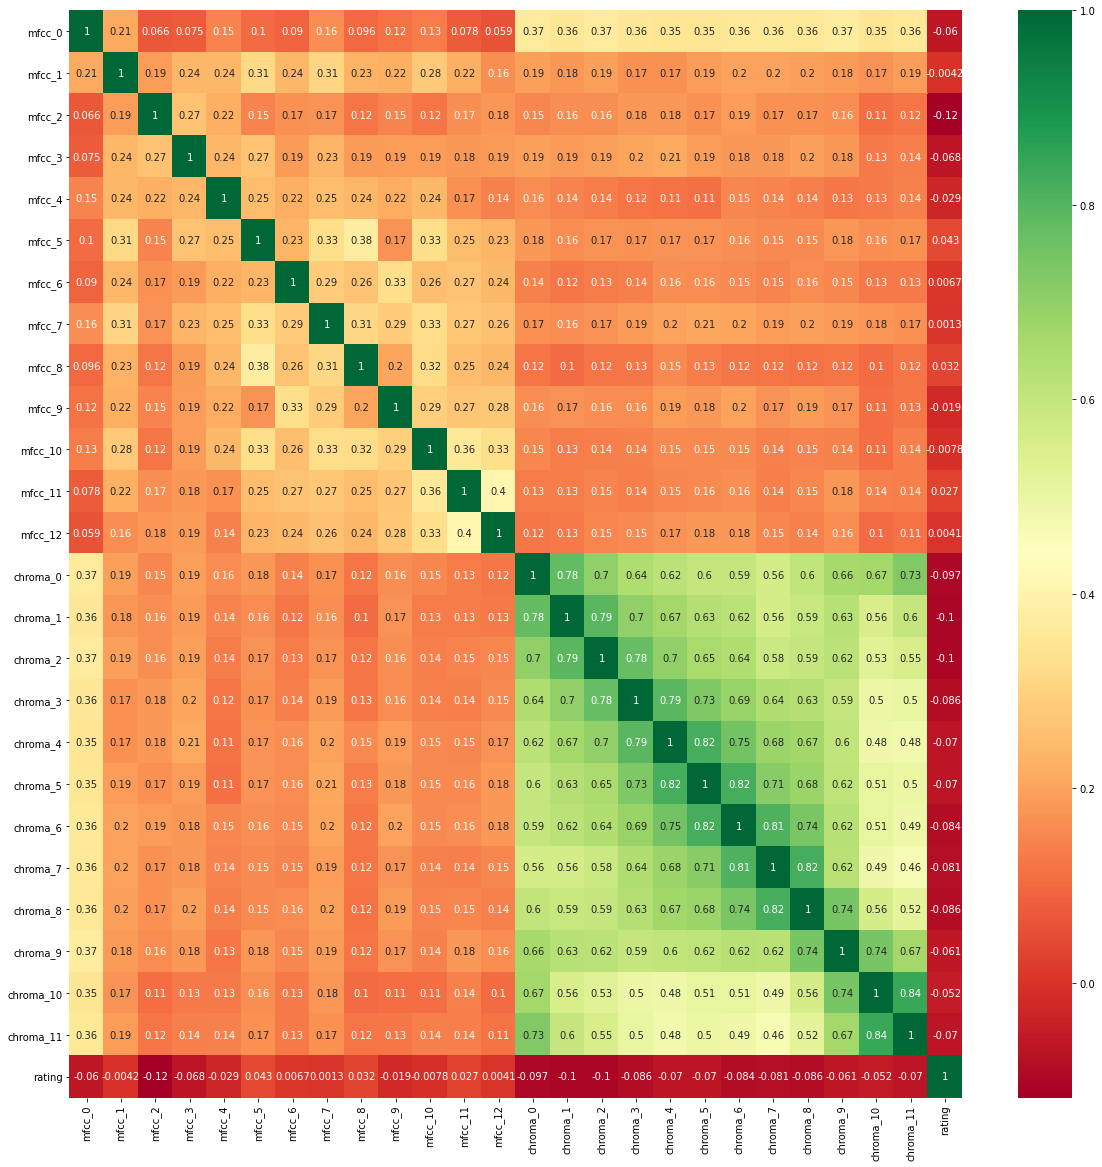

In [239]:
# visualize correlation between min of audio features
data = min_df_cp.drop(['video_id', 'frames'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

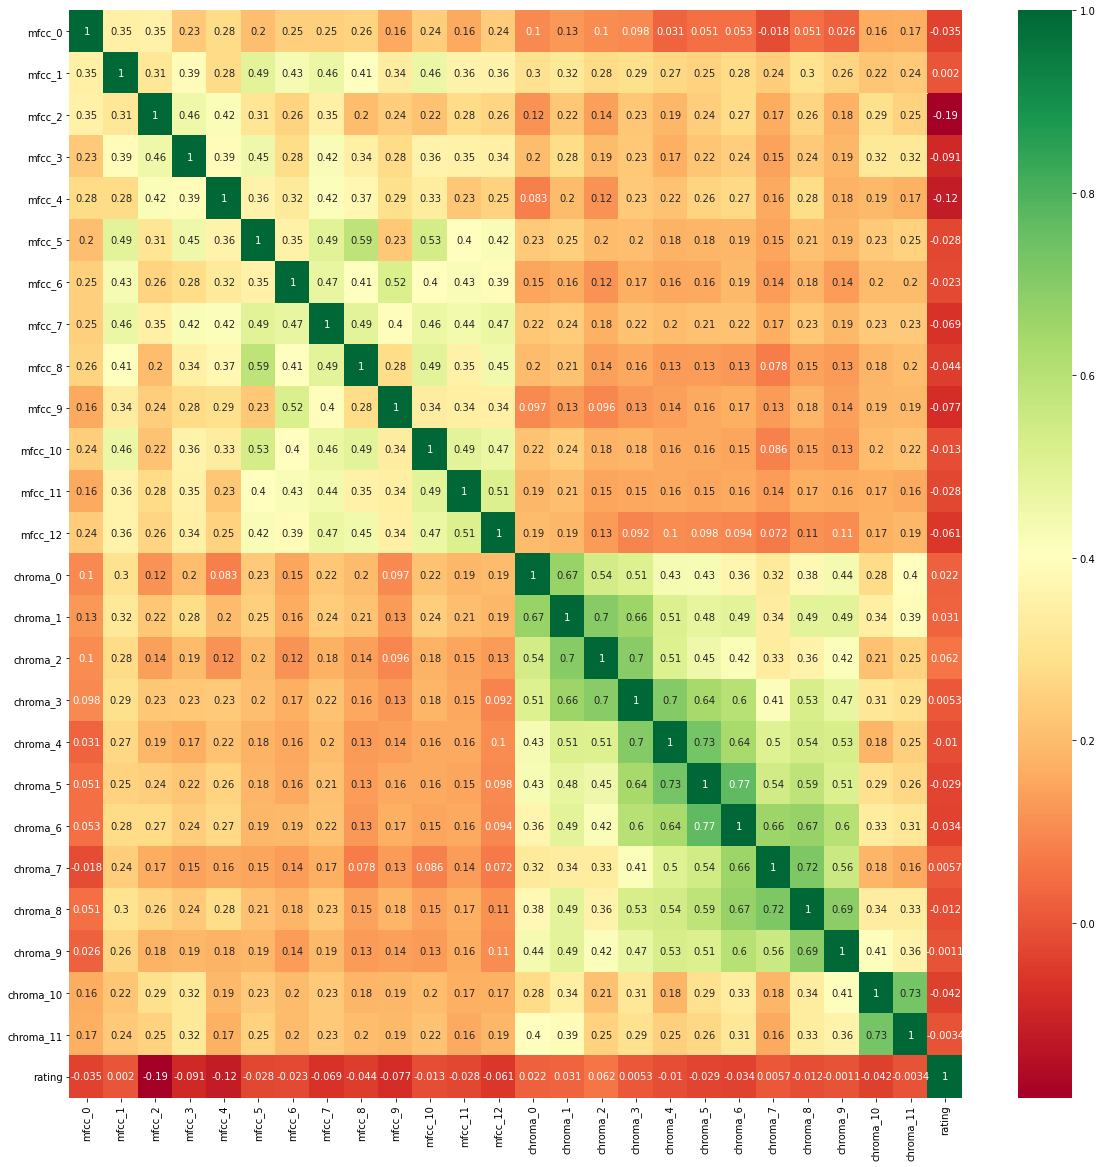

In [240]:
# visualize correlation between mean of audio features
data = interquantile_df_cp.drop(['video_id', 'frames'], axis=1)
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20, 20))
g=sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")